# 14 News Popularity Prediction

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', palette='muted')

from scipy.stats import skew, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

# Boosting algorithm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:

## View the dataset and details of it
def view_details(dataframe):
    df_sample = dataframe.head(2).append(dataframe.tail(2))
    # Display the dataset
    print(df_sample)
    # Show the fields description
    dataframe.info()

# Distribution plot with KDE enabled
def kde_plot(data):
    fig = plt.figure()
    
    sns.distplot(data)
    plt.show()
    
def correlation_plot(corr_data):
    fig = plt.figure(figsize=(12,7))
    
    sns.heatmap(corr_data, annot=True)
    plt.tight_layout()
    plt.show()
    
# Calculating Multicollinearity score
def compute_mulcol_score(dataframe, score_range):
    mul_score = pd.DataFrame()
    mul_score['Variables'] = dataframe.columns
    mul_score['VIF'] = [variance_inflation_factor(dataframe.values, i) 
                         for i in range(dataframe.shape[1])]
    
    # Score that are less than 5 will be selected
    non_mul_col = [item[0] for item in mul_score.values if item[1] < score_range]

    return non_mul_col

def reduce_dim(data_df):
    n_dim = 10
    svd = TruncatedSVD(n_components=n_dim, n_iter=10, random_state=42).fit(data_df)
    
    svd_matrix = svd.transform(data_df)
    
    return svd_matrix
    

In [191]:
# Loading the dataset
train_data = pd.read_csv('./data/Train.csv', header=0)
test_data = pd.read_csv('./data/Test.csv', header=0)
submit_data = pd.read_csv('./data/sample_submission.csv', header=0)


In [192]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7928 entries, 0 to 7927
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 7928 non-null   float64
 1   n_tokens_content               7928 non-null   float64
 2   n_unique_tokens                7928 non-null   float64
 3   n_non_stop_words               7928 non-null   float64
 4   n_non_stop_unique_tokens       7928 non-null   float64
 5   num_hrefs                      7928 non-null   float64
 6   num_self_hrefs                 7928 non-null   float64
 7   num_imgs                       7928 non-null   float64
 8   num_videos                     7928 non-null   float64
 9   average_token_length           7928 non-null   float64
 10  num_keywords                   7928 non-null   float64
 11  data_channel_is_lifestyle      7928 non-null   float64
 12  data_channel_is_entertainment  7928 non-null   f

In [187]:
n_col = [col for col in train_data if col.startswith('n_')]
num_col = [col for col in train_data if col.startswith('num')]
LDA_col = [col for col in train_data if col.startswith('LDA')]
weekday_col = [col for col in train_data if col.startswith('weekday')]
data_channel_col = [col for col in train_data if col.startswith('data_channel')]
kw_max_col = [col for col in train_data if col.startswith('kw_max')]
kw_avg_col = [col for col in train_data if col.startswith('kw_avg')]
kw_min_col = [col for col in train_data if col.startswith('kw_min')]
self_reference_col = [col for col in train_data if col.startswith('self_reference')]
polarity_col = [col for col in train_data if col.endswith('polarity')]


<Figure size 432x288 with 0 Axes>

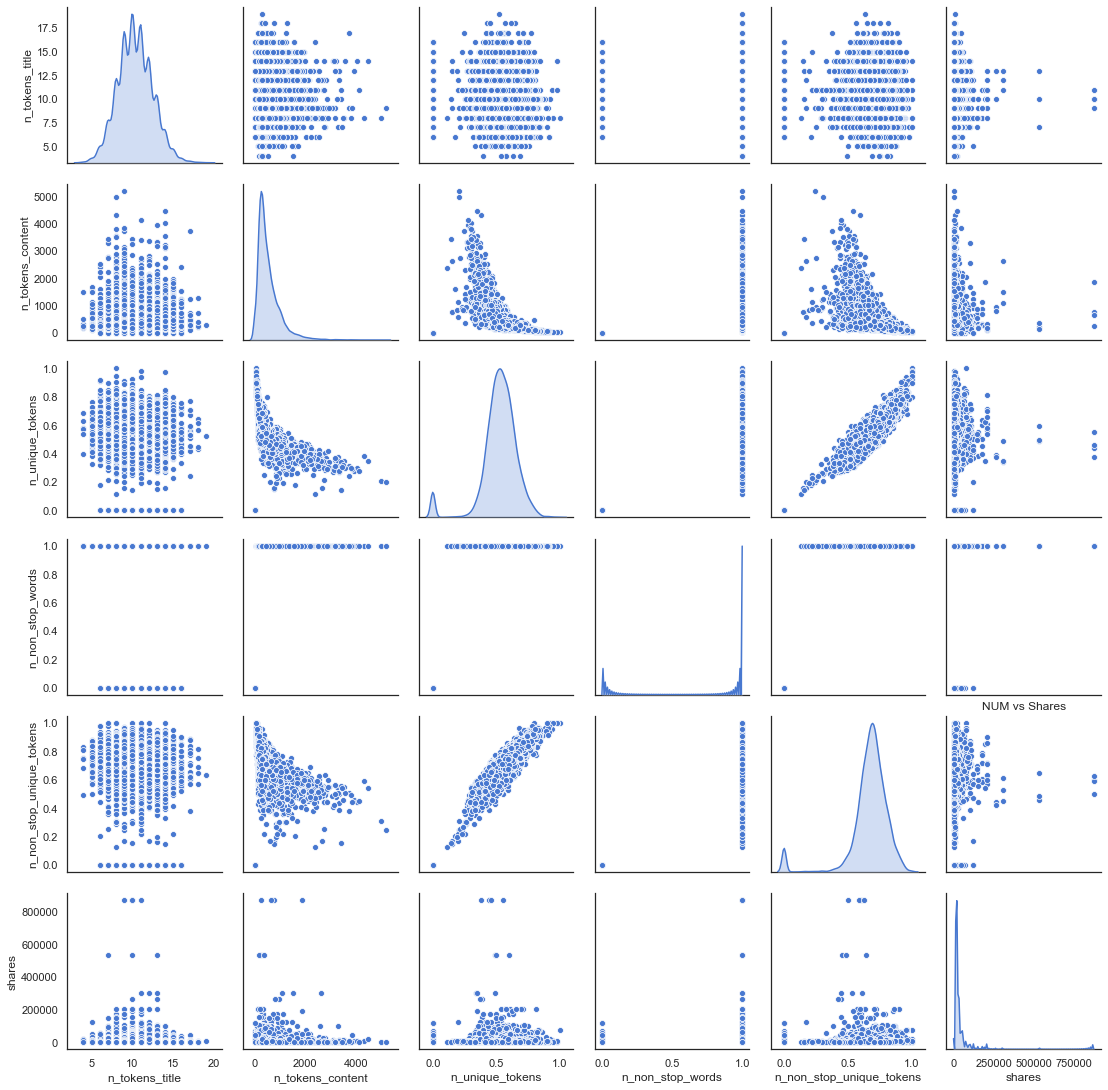

In [167]:
compare_df = pd.concat([train_data[n_col], train_data['shares']], axis=1)

plt.figure()
sns.pairplot(compare_df, diag_kind='kde')
plt.title('NUM vs Shares')
# sns.scatterplot(x=train_data['kw_min_max'], y=train_data['shares'])
plt.show()

In [217]:
feature_cols =['n_unique_tokens', 'n_tokens_title', 'n_tokens_content']

In [218]:
feature_cols

['n_unique_tokens', 'n_tokens_title', 'n_tokens_content']

<Figure size 432x288 with 0 Axes>

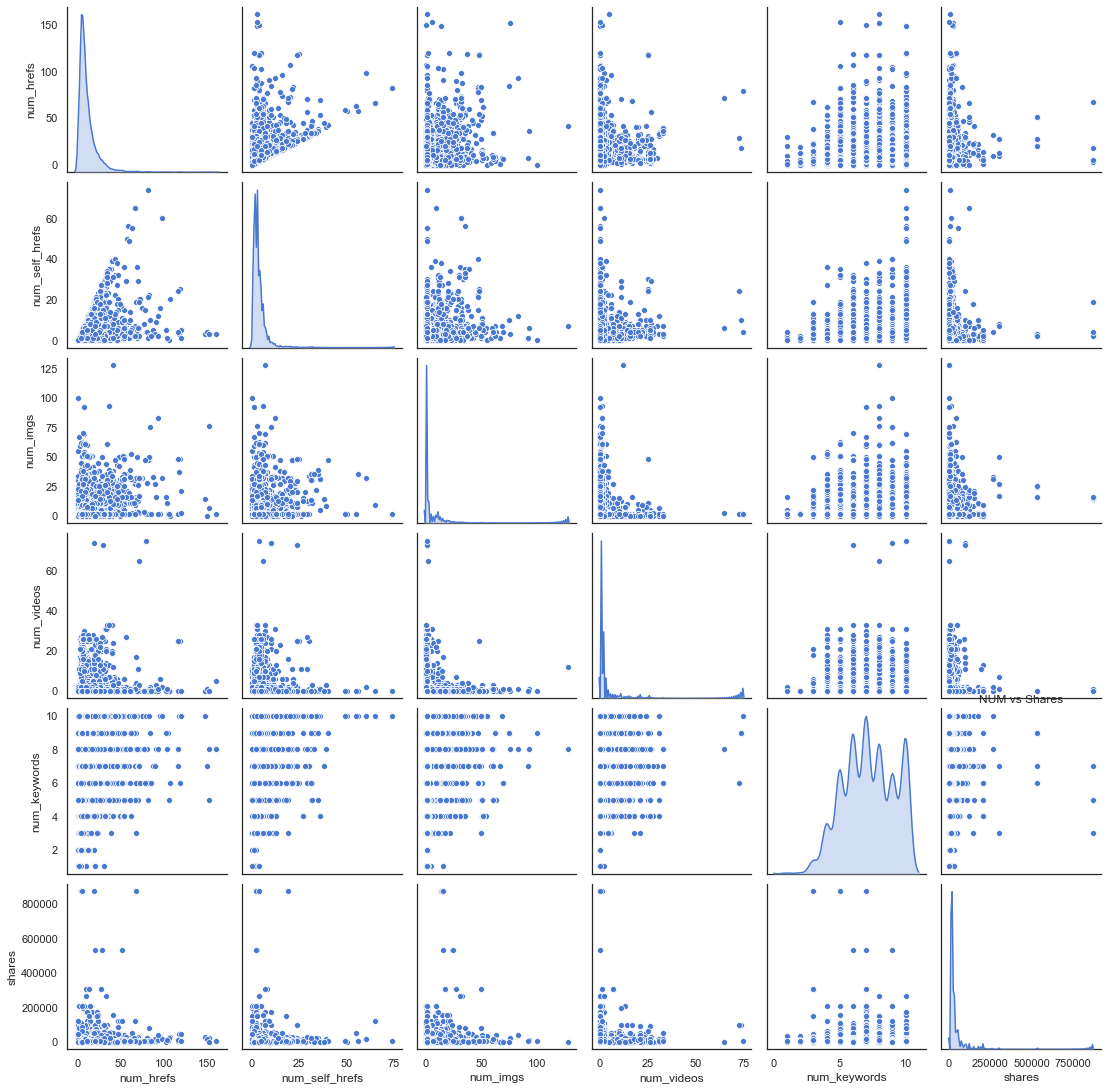

In [168]:
compare_df = pd.concat([train_data[num_col], train_data['shares']], axis=1)

plt.figure()
sns.pairplot(compare_df, diag_kind='kde')
plt.title('NUM vs Shares')
# sns.scatterplot(x=train_data['kw_min_max'], y=train_data['shares'])
plt.show()

In [219]:
feature_cols = feature_cols + ['num_hrefs', 'num_keywords']

In [220]:
feature_cols

['n_unique_tokens',
 'n_tokens_title',
 'n_tokens_content',
 'num_hrefs',
 'num_keywords']

<Figure size 432x288 with 0 Axes>

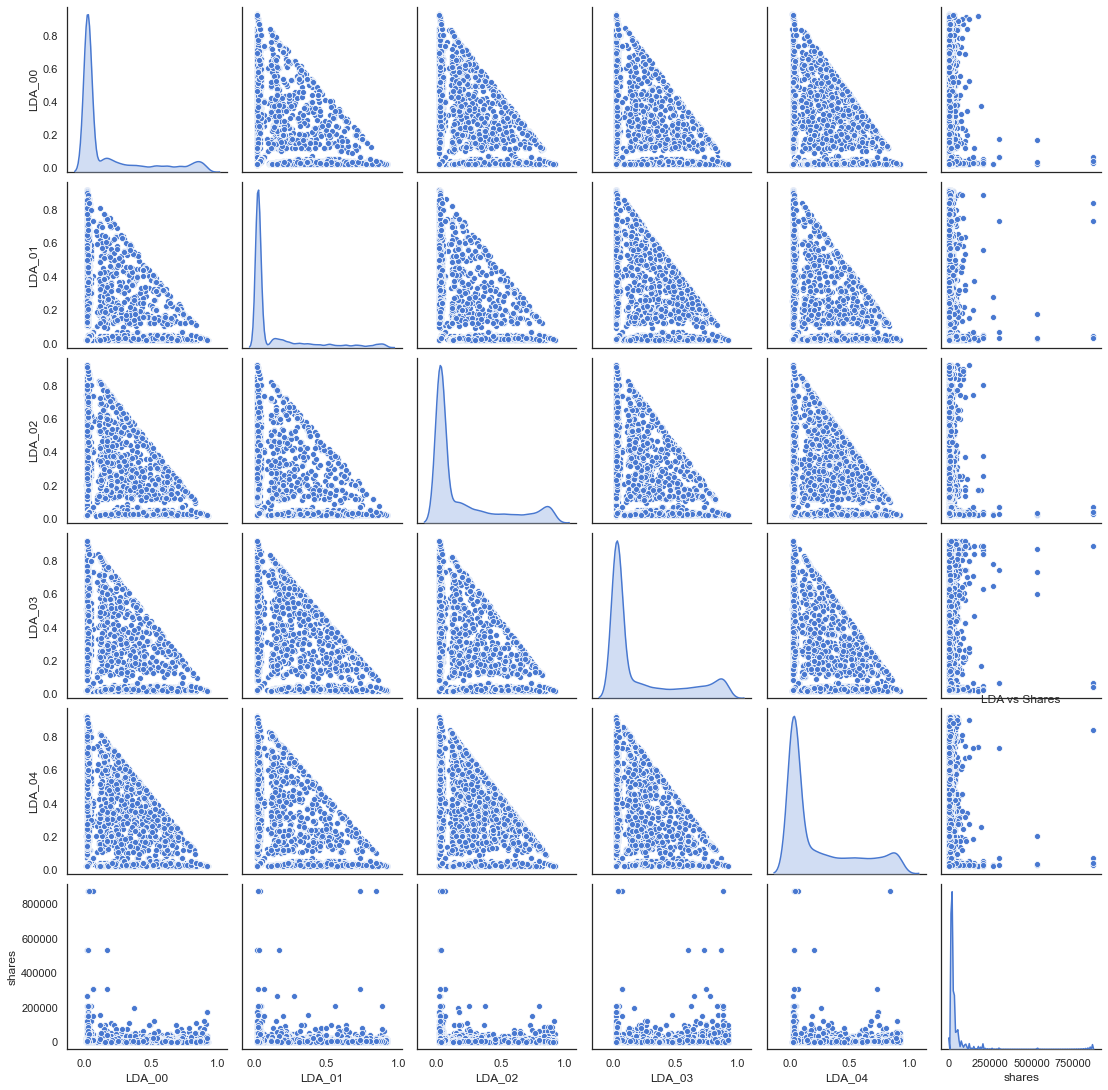

In [163]:
compare_df = pd.concat([train_data[LDA_col], train_data['shares']], axis=1)

plt.figure()
sns.pairplot(compare_df, diag_kind='kde')
plt.title('LDA vs Shares')
# sns.scatterplot(x=train_data['kw_min_max'], y=train_data['shares'])
plt.show()


In [221]:
feature_cols = feature_cols + ['title_sentiment_polarity', 'min_positive_polarity', 'global_subjectivity', 'n_non_stop_words', 'weekday_is_friday', 'kw_min_avg', 'kw_avg_max', 'max_negative_polarity', 'title_subjectivity', 'kw_max_max', 'kw_min_min', 'data_channel_is_socmed', 'num_imgs', 'max_positive_polarity', 'abs_title_sentiment_polarity', 'LDA_01', 'num_self_hrefs', 'abs_title_subjectivity', 'global_rate_positive_words']

In [233]:
feature_cols = sorted(feature_cols)
print(feature_cols)

['LDA_01', 'abs_title_sentiment_polarity', 'abs_title_subjectivity', 'data_channel_is_socmed', 'global_rate_positive_words', 'global_subjectivity', 'kw_avg_max', 'kw_max_max', 'kw_min_avg', 'kw_min_min', 'max_negative_polarity', 'max_positive_polarity', 'min_positive_polarity', 'n_non_stop_words', 'n_tokens_content', 'n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_imgs', 'num_keywords', 'num_keywords', 'num_self_hrefs', 'title_sentiment_polarity', 'title_subjectivity', 'weekday_is_friday']


<Figure size 432x288 with 0 Axes>

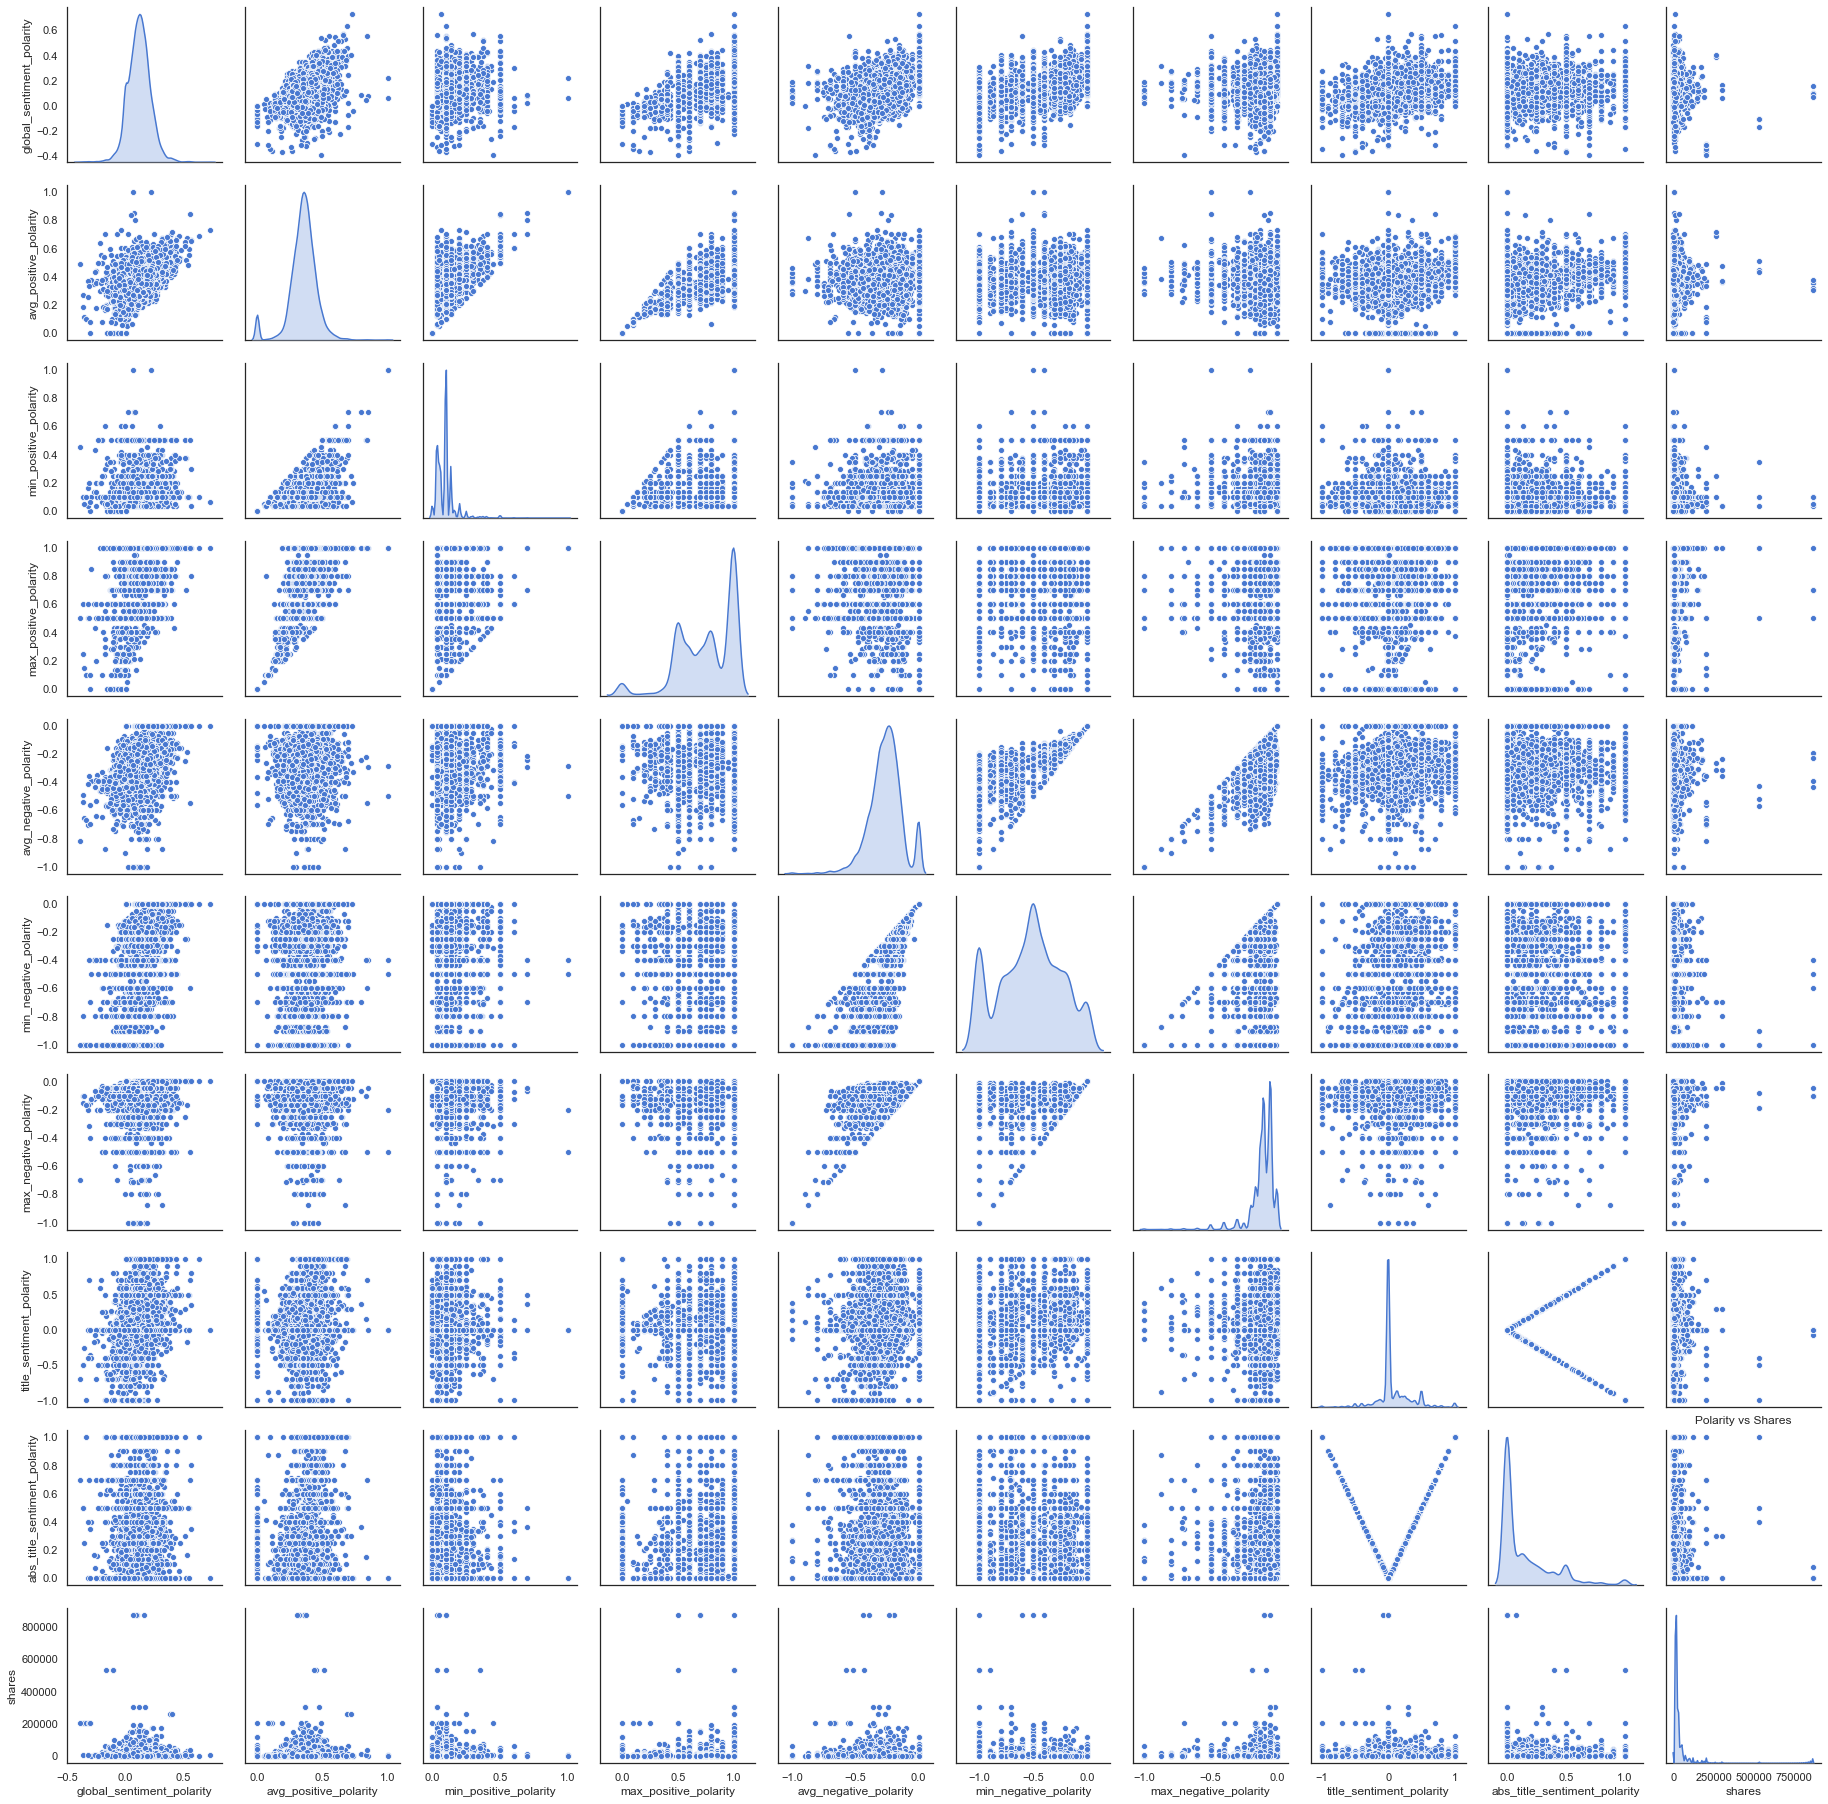

In [188]:
compare_df = pd.concat([train_data[polarity_col], train_data['shares']], axis=1)

plt.figure()
sns.pairplot(compare_df, diag_kind='kde')
plt.title('Polarity vs Shares')

plt.show()


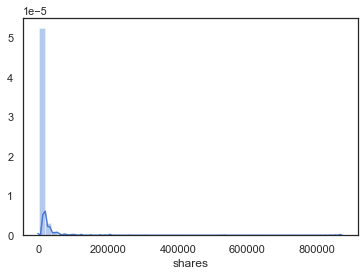

Skewness of Y: 20.346116262432247


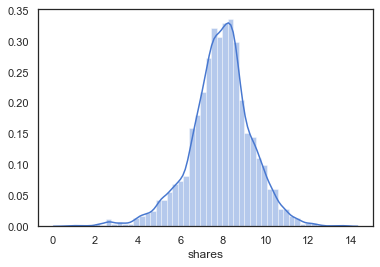

Skewness of Y: -0.434280773622946
False


In [26]:
# Plot the target variable
kde_plot(Y)

# finding skewness in the data
y_skew = skew(Y)
print(f"Skewness of Y: {y_skew}")

# Apply log transformation
y_log_values = np.log1p(Y)

kde_plot(y_log_values)
print(f"Skewness of Y: {skew(y_log_values)}")

# Checking null or missing values
print(train_data.isnull().sum().any())

In [31]:
# Checking duplicates
train_duplicates = train_data[train_data.duplicated()]
test_duplicates = test_data[test_data.duplicated()]

print("Train {} and Test {} duplicates".format(train_duplicates.shape[0], test_duplicates.shape[0]))

Train 0 and Test 0 duplicates


In [136]:
# Checking Multicollinearity
good_cols = compute_mulcol_score(X, 3)

# features = compute_mulcol_score(X[good_cols], 5)
print("Columns with less than VIF:\n {} \n count {}".format(good_cols, len(good_cols)))

Columns with less than VIF:
 ['num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_min_min', 'kw_min_max', 'kw_min_avg', 'max_negative_polarity', 'title_sentiment_polarity'] 
 count 12


In [ ]:
# Removing one-hot encoded columns


In [110]:
features = good_cols

# features.append('shares')

print(features)
train_data[features]


['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'kw_min_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'global_subjectivity', 'global_rate_positive_words', 'min_positive_polarity', 'max_positive_polarity', 'max_negative_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity']


,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_socmed,...,kw_min_avg,global_subjectivity,global_rate_positive_words,min_positive_polarity,max_positive_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,9.0,286.0,6.0,4.0,2.0,1.0,9.0,0.0,0.0,0.0,...,0.000000,0.433628,0.048951,0.136364,1.0,0.000000,0.000000,0.000000,0.500000,0.000000
1,10.0,96.0,4.0,3.0,10.0,1.0,8.0,0.0,0.0,0.0,...,2042.608696,0.733333,0.041667,0.200000,0.5,-0.600000,1.000000,0.500000,0.500000,0.500000
2,9.0,399.0,21.0,1.0,20.0,0.0,9.0,0.0,0.0,0.0,...,0.000000,0.356277,0.027569,0.100000,0.6,-0.100000,0.535714,0.285714,0.035714,0.285714
3,11.0,1388.0,40.0,4.0,2.0,5.0,10.0,1.0,0.0,0.0,...,0.000000,0.446667,0.046830,0.033333,1.0,-0.050000,1.000000,-0.500000,0.500000,0.500000
4,12.0,499.0,10.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,...,0.000000,0.527349,0.062124,0.100000,0.6,-0.100000,0.650000,0.350000,0.150000,0.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7923,12.0,260.0,5.0,2.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.000000,0.354809,0.026923,0.136364,0.5,-0.100000,0.400000,-0.250000,0.100000,0.250000
7924,8.0,277.0,4.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,...,0.000000,0.369048,0.025271,0.200000,0.6,-0.071429,0.500000,0.500000,0.000000,0.500000
7925,12.0,299.0,8.0,6.0,1.0,0.0,7.0,0.0,0.0,0.0,...,1655.500000,0.457822,0.046823,0.136364,0.6,-0.050000,0.200000,0.300000,0.300000,0.300000
7926,14.0,449.0,5.0,4.0,1.0,0.0,9.0,0.0,0.0,0.0,...,2079.143129,0.486974,0.057906,0.100000,0.6,-0.066667,0.266667,0.175000,0.233333,0.175000


## Correlation

In [44]:
def find_correlation_with_y(dataframe):
    columns = dataframe.columns
    y = train_data['shares']
    col_dict = {}
    for col in columns:
        X = train_data[col].values
        
        r = np.round(pearsonr(X, y),2)
        
        if np.abs(r[1]) > 0.3:
            col_dict[col] = r
            
    return col_dict

high_corr_cols = find_correlation_with_y(train_data)

column_list = list(high_corr_cols.keys())

# Take the unique fields
distinct_col = set(good_cols + column_list)
print("Distinct col:", distinct_col, len(distinct_col))

Distinct col: {'n_unique_tokens', 'n_tokens_content', 'num_hrefs', 'data_channel_is_entertainment', 'n_tokens_title', 'average_token_length', 'weekday_is_wednesday', 'kw_min_max', 'weekday_is_monday', 'weekday_is_saturday', 'num_videos', 'data_channel_is_lifestyle', 'title_sentiment_polarity', 'min_positive_polarity', 'global_subjectivity', 'n_non_stop_words', 'weekday_is_friday', 'kw_min_avg', 'num_keywords', 'kw_avg_max', 'max_negative_polarity', 'title_subjectivity', 'kw_max_max', 'kw_min_min', 'data_channel_is_socmed', 'num_imgs', 'max_positive_polarity', 'abs_title_sentiment_polarity', 'LDA_01', 'num_self_hrefs', 'abs_title_subjectivity', 'global_rate_positive_words'} 32


In [45]:
print(distinct_col)

{'n_unique_tokens', 'n_tokens_content', 'num_hrefs', 'data_channel_is_entertainment', 'n_tokens_title', 'average_token_length', 'weekday_is_wednesday', 'kw_min_max', 'weekday_is_monday', 'weekday_is_saturday', 'num_videos', 'data_channel_is_lifestyle', 'title_sentiment_polarity', 'min_positive_polarity', 'global_subjectivity', 'n_non_stop_words', 'weekday_is_friday', 'kw_min_avg', 'num_keywords', 'kw_avg_max', 'max_negative_polarity', 'title_subjectivity', 'kw_max_max', 'kw_min_min', 'data_channel_is_socmed', 'num_imgs', 'max_positive_polarity', 'abs_title_sentiment_polarity', 'LDA_01', 'num_self_hrefs', 'abs_title_subjectivity', 'global_rate_positive_words'}


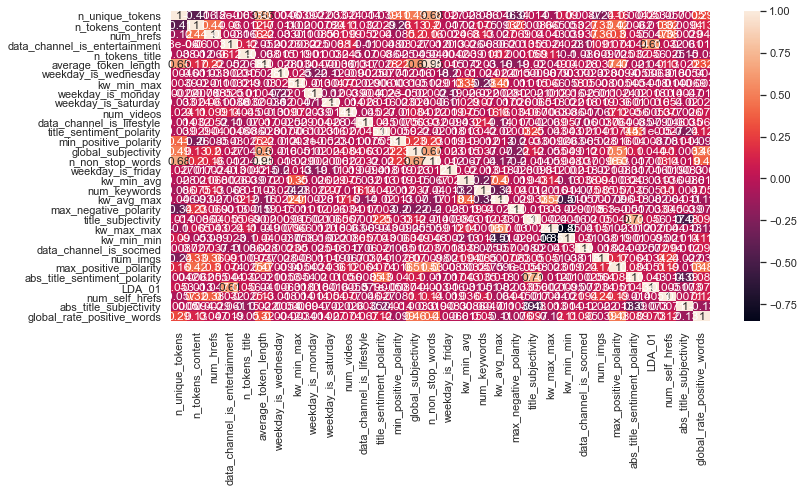

In [46]:
corr = train_data[distinct_col].corr()

correlation_plot(corr)

## Dimension Reduction

In [47]:
# features.remove('shares')
features = distinct_col
X = train_data[features]
y = train_data['shares']
X_test = test_data[features]

In [48]:
X.columns

Index(['n_unique_tokens', 'n_tokens_content', 'num_hrefs',
       'data_channel_is_entertainment', 'n_tokens_title',
       'average_token_length', 'weekday_is_wednesday', 'kw_min_max',
       'weekday_is_monday', 'weekday_is_saturday', 'num_videos',
       'data_channel_is_lifestyle', 'title_sentiment_polarity',
       'min_positive_polarity', 'global_subjectivity', 'n_non_stop_words',
       'weekday_is_friday', 'kw_min_avg', 'num_keywords', 'kw_avg_max',
       'max_negative_polarity', 'title_subjectivity', 'kw_max_max',
       'kw_min_min', 'data_channel_is_socmed', 'num_imgs',
       'max_positive_polarity', 'abs_title_sentiment_polarity', 'LDA_01',
       'num_self_hrefs', 'abs_title_subjectivity',
       'global_rate_positive_words'],
      dtype='object')

In [49]:
n_dim = 15

svd = TruncatedSVD(n_components=n_dim, n_iter=10, random_state=42).fit(X)

svd_train_matrix = svd.transform(X)

svd_test_matrix = svd.transform(X_test)

In [50]:
svd_train_df = pd.DataFrame(svd_train_matrix)

In [51]:
svd_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,928613.855233,89995.098459,-45356.263280,1461.732158,-141.404740,13.592069,-0.535317,0.333695,0.216210,2.174420,-0.750715,-2.661556,-0.441369,-0.037007,-0.225716
1,89168.753902,11390.678813,-591.113433,-1883.388250,-11.641452,198.140577,0.774512,7.796277,1.435265,0.667265,3.275963,-1.376663,-0.481232,0.028823,0.404201
2,887514.641081,-21533.089917,-10026.463387,1093.222687,-141.690678,5.178605,17.208732,12.210541,-1.543015,-3.382400,-0.375020,-1.584048,-0.438252,0.027592,0.127892
3,871779.698889,-64234.432307,3500.906050,918.180050,802.754526,-29.247383,17.032474,-13.086809,0.112073,-3.702635,1.190323,-1.239482,0.893199,-0.587463,0.283828
4,872931.613145,-61106.233407,2509.511674,960.365082,-82.297427,0.052826,-0.724057,-2.469480,-2.108748,-2.071648,1.598373,1.207444,-0.270761,-0.592268,0.326048


## Scale the features

In [250]:
feature_cols = list(set(feature_cols))

In [251]:
feature_cols

['n_unique_tokens',
 'n_tokens_content',
 'num_hrefs',
 'kw_min_min',
 'n_tokens_title',
 'data_channel_is_socmed',
 'num_imgs',
 'title_sentiment_polarity',
 'max_positive_polarity',
 'min_positive_polarity',
 'global_subjectivity',
 'n_non_stop_words',
 'weekday_is_friday',
 'kw_min_avg',
 'abs_title_sentiment_polarity',
 'LDA_01',
 'kw_avg_max',
 'max_negative_polarity',
 'num_keywords',
 'num_self_hrefs',
 'title_subjectivity',
 'abs_title_subjectivity',
 'kw_max_max',
 'global_rate_positive_words']

In [252]:
X = train_data[feature_cols]
y = train_data['shares']
X_test = test_data[feature_cols]

scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)


In [254]:
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

## Model Building

In [255]:
lgb_params={
    'learning_rate': 0.1,
    'objective':'regression',
    'importance_type':'split',
    'metric':'rmse',
    'num_leaves': 31,
    "random_state":42,
    'max_depth': 6,
    "bagging_seed" : 42,
    "bagging_frequency" : 5,
    "reg_alpha":0.6,
    "reg_lambda":0.6,
    'min_child_samples': 20,
    'min_child_weight':0.6
}

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.15,
    'max_depth': 6,
    'min_child_weight': 0.6
}

cat_param = {
    'iterations':600,
    'learning_rate' :0.15,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period' : 50,
    'od_wait' : 20,
    'random_seed' : 42,
    'bagging_temperature':0.2
}

In [256]:
lgbm = LGBMRegressor(**lgb_params, n_estimators=900)

xgb = XGBRegressor(**xgb_params, n_estimators=700)

# Set up classifier
cat = CatBoostRegressor(**cat_param)


## Build a Ridge Model

In [257]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(normalize=True, cv=15, alphas=alphas, gcv_mode='svd')

ridge_reg = TransformedTargetRegressor(regressor= ridge_cv,
                                      func=np.log1p,
                                      inverse_func=np.expm1)

In [258]:
ridge_reg.fit(X_scaled_df, y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                             cv=15, gcv_mode='svd',
                                             normalize=True))

In [259]:
ridge_preds = ridge_reg.predict(X_test_scaled)

In [260]:
ridge_preds

array([5518.30685997, 2697.3970396 , 1866.50774479, ..., 2003.06658692,
       1943.51417117, 2553.92442202])

In [263]:
K = 10
kfolds = KFold(n_splits=K, shuffle=True, random_state=42)

error_list = []
preds_list = []

for i, (train_idx, test_idx) in enumerate(kfolds.split(X_scaled_df.values, y.values)):
    
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    X_train, X_valid = X_scaled_df.iloc[train_idx], X_scaled_df.iloc[test_idx]
    
#     ridge_reg.fit(X_train, y_train)
    
    print("-"* 20 + "Catboost Training" + "-"* 20)
    cat.fit(X_train, np.log1p(y_train), 
            eval_set=[(X_valid, np.log1p(y_valid))],
            early_stopping_rounds=50,
            use_best_model=True,verbose=100)
    
    
    y_preds = np.expm1(cat.predict(X_valid))
    error_val = np.sqrt(mean_squared_error(y_valid, y_preds))
    print("Fold {0}, Error: {1}".format(i, error_val))
    
#     error_list.append(error_val)
#     y_test_preds = xgb.predict(X_test_scaled)
    
#     preds_list.append(y_test_preds)



--------------------Catboost Training--------------------
0:	learn: 1.4501653	test: 1.4970804	best: 1.4970804 (0)	total: 37.3ms	remaining: 22.3s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.491411233
bestIteration = 5

Shrink model to first 6 iterations.
Fold 0, Error: 19257.045677665836
--------------------Catboost Training--------------------
0:	learn: 1.4559779	test: 1.4667765	best: 1.4667765 (0)	total: 33.9ms	remaining: 20.3s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.435793906
bestIteration = 32

Shrink model to first 33 iterations.
Fold 1, Error: 28156.606373324576
--------------------Catboost Training--------------------
0:	learn: 1.4613178	test: 1.3966423	best: 1.3966423 (0)	total: 61.1ms	remaining: 36.6s


100:	learn: 0.9875358	test: 1.3631581	best: 1.3607323 (70)	total: 3.8s	remaining: 18.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.35908906
bestIteration = 109

Shrink model to first 110 iterations.
Fold 2, Error: 44862.627784112155
--------------------Catboost Training--------------------
0:	learn: 1.4571070	test: 1.4440086	best: 1.4440086 (0)	total: 33.4ms	remaining: 20s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.416386749
bestIteration = 41

Shrink model to first 42 iterations.
Fold 3, Error: 13676.464642898367
--------------------Catboost Training--------------------
0:	learn: 1.4637167	test: 1.3509111	best: 1.3509111 (0)	total: 65ms	remaining: 38.9s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.343148482
bestIteration = 16

Shrink model to first 17 iterations.
Fold 4, Error: 14985.400762944575
--------------------Catboost Training--------------------
0:	learn: 1.4510863	test: 1.4784910	best: 1.4784910 (0)	total: 42.9ms	remaining: 25.7s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465821134
bestIteration = 23

Shrink model to first 24 iterations.
Fold 5, Error: 34216.68056484355
--------------------Catboost Training--------------------
0:	learn: 1.4487533	test: 1.5042890	best: 1.5042890 (0)	total: 36.6ms	remaining: 21.9s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.444308048
bestIteration = 48

Shrink model to first 49 iterations.
Fold 6, Error: 17674.66394938905
--------------------Catboost Training--------------------
0:	learn: 1.4587024	test: 1.4308769	best: 1.4308769 (0)	total: 64.4ms	remaining: 38.6s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.419288864
bestIteration = 7

Shrink model to first 8 iterations.
Fold 7, Error: 18491.41090189387
--------------------Catboost Training--------------------
0:	learn: 1.4490353	test: 1.5033847	best: 1.5033847 (0)	total: 38ms	remaining: 22.8s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.466000505
bestIteration = 24

Shrink model to first 25 iterations.
Fold 8, Error: 32179.422010800507
--------------------Catboost Training--------------------
0:	learn: 1.4445687	test: 1.5315444	best: 1.5315444 (0)	total: 59.8ms	remaining: 35.8s


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.510859644
bestIteration = 16

Shrink model to first 17 iterations.
Fold 9, Error: 34791.12604156291


In [264]:
cat_preds = np.expm1(cat.predict(X_test_scaled))

In [265]:
cat_preds

array([4577.1553384 , 2227.96389304, 2012.80227115, ..., 1579.23662256,
       2370.36130445, 2261.34953888])

In [269]:
prediction = ridge_preds * 0.3 + cat_preds * 0.7

In [270]:
prediction

array([4859.50079487, 2368.79383701, 1968.91391324, ..., 1706.38561187,
       2242.30716447, 2349.12200382])

In [273]:
final_df = pd.DataFrame({'shares': ridge_preds}, index=test_data.index)

# final_df['SalesInMillions'] = final_df.apply(lambda x: round(x, 6))
final_df.to_csv('./data/newspopular_ridge_01.csv', float_format='%.1f', index=False)